In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme(context='poster', style='ticks', font='Helvetica')

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

We load the original dataframe because we need to calculate some 'random' probabilities. Basically, the abundance of classes in the dataset. This would be the base association rate if nothing else would be influencing the association of ribosomes.

In [2]:
df_wt = pd.read_csv("../data/results/dataframe.csv", index_col=0)
df_wt['in_chain'] = ((df_wt['trailing_id'] != -1) | (df_wt['leading_id'] != -1))  # this line can be removed

In [3]:
np.unique(df_wt['elongation'])

array(['Dec', 'Post', 'Pre', 'Pre+', 'Rot1', 'Rot1+', 'Rot2', 'RotIdle',
       'Translocation', 'UnRotIdle', 'Unk'], dtype=object)

In [4]:
total = df_wt[df_wt.elongation != 'Unk'].shape[0]
for state in np.unique(df_wt['elongation']):
    print(state, 100 * df_wt[df_wt['elongation'] == state].shape[0] / total)

Dec 20.382107863504846
Post 10.206918433795922
Pre 2.9341774255690445
Pre+ 30.244539967213363
Rot1 4.003898134787831
Rot1+ 3.1698785987867435
Rot2 15.532102953063738
RotIdle 3.4380642285697016
Translocation 4.373314396657878
UnRotIdle 5.714997998050933
Unk 1.495040454480211


## Plotting elongations state abundance in polysome chains

In [5]:

subset = df_wt[df_wt.elongation != 'Unk']
elongation_dict = {s: [] for s in np.unique(subset.elongation)}
for i, tomo in enumerate(np.unique(subset.tomogram)):
    if i % 100 == 0: print(i)
    tomo_subset = subset[subset.tomogram == tomo]
    for elong in np.unique(subset.elongation):
        elong_subset = tomo_subset[tomo_subset.elongation == elong]
        if elong_subset.shape[0] == 0:
            elongation_dict[elong].append(.0)
        else:
            elongation_dict[elong].append(elong_subset[elong_subset.in_chain == True].shape[0] / elong_subset.shape[0])

0
100
200
300
400
500
600
700
800


Dec
Pre+
Pre
Rot1+
Rot1
Rot2
Post
Translocation
UnRotIdle
RotIdle


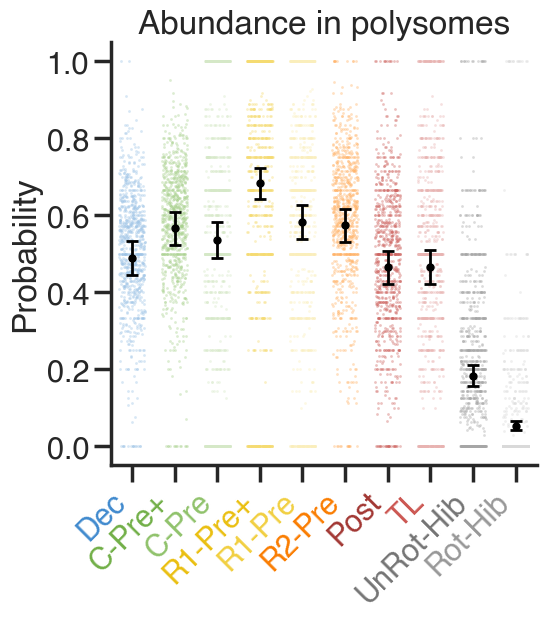

In [6]:
order = ['Dec', 'Pre+', 'Pre', 'Rot1+', 'Rot1', 
                             'Rot2', 'Post', 'Translocation', 'UnRotIdle', 'RotIdle']

prediction = pd.read_csv("../data/results/mblogit_elongation-state-in-chain.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# these are the labels corresponding to the new order
labels = ['Dec', 'C-Pre+', 'C-Pre', 'R1-Pre+', 'R1-Pre',
          'R2-Pre', 'Post', 'TL', 'UnRot-Hib', 'Rot-Hib']

# dictionary with some name conversions
name_conv = {'Dec': 'Dec', 'Pre+': 'C-Pre+', 'Pre': 'C-Pre', 'R1+': 'R1-Pre+', 'R1': 'R1-Pre',
             'R2': 'R2-Pre', 'Tra': 'TL', 'Post': 'Post', 'RI': 'Rot-Hib', 'URI': 'UnRot-Hib', 
             'Unk': 'Unk', 'non': 'Empty', 'Pre_1': 'C-Pre+', 'Rot1': 'R1-Pre', 'Rot1+': 'R1-Pre+',
             'Translocation': 'TL', 'Rot2': 'R2-Pre', 'RotIdle': 'Rot-Hib', 'UnRotIdle': 'UnRot-Hib'}

# specific colors matching with the papers
colors = {'Dec': '#9DC3E6', 'C-Pre+': '#A9D18E', 'C-Pre': '#D5E8C7', 'R1-Pre+': '#F5DB71', 'R1-Pre': '#FAEEBB',
          'R2-Pre': '#FFB266', 'Post': '#CE6662', 'TL': '#E8B3B1', 'Rot-Hib': '#D9D9D9', 'UnRot-Hib': '#A6A6A6', 
          'Unk': 'black', 'Empty': 'white'}


xs = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(figsize=(5.5,5.5))

ax.errorbar(xs, prediction['prob.TRUE'], yerr=[prediction['prob.TRUE'] - prediction['L.prob.TRUE'], 
                      prediction['U.prob.TRUE'] - prediction['prob.TRUE']], 
            capsize=4, capthick=2, elinewidth=2, fmt='.', color='black', ms=10, zorder=2)

for x, (rowname, _) in zip(xs, prediction.iterrows()):
    print(rowname)
    values = elongation_dict[rowname]
    sns.stripplot(x=x, y=values, s=2, color=colors[name_conv[rowname]], zorder=1, ax=ax, alpha=0.4, jitter=0.3)

ax.yaxis.grid(True)
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, ha='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_title('Abundance in polysomes')
ax.set_ylim((-.05, 1.05))
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.grid(False)  # remove grid line
sns.despine()

plt.savefig('../data/results/mblogit_elongation-state-in-chain.png', dpi=600, bbox_inches='tight')

## Polysome neighbour translocon probability

In [5]:
# calculate probabilities over full dataset based purely on abundance
# our expected probably would be equal to this if our classes dont have any influence association
#  => a null hypothesis if you will
n = df_wt.shape[0]
null_hypothesis = {s: df_wt[df_wt.state == s].shape[0] / n for s in np.unique(df_wt.state)}
null_hypothesis

# for this we need the separate dataframe we stored in R
raw = pd.read_csv("../data/results/mblogit_overall-polysome-neighbour-probability_raw-data.csv", 
                  delimiter=',', index_col=0)

# calculate the occurence of the neighbours in each tomogram for each state
polysome_dict = {s: {s: [] for s in np.unique(raw.n_state_full)} for s in np.unique(raw.state)}
for i, tomo in enumerate(np.unique(raw.tomogram)):
    if i % 100 == 0: print(i)
    
    # select one tomogram
    raw_tomo = raw[raw.tomogram == tomo]
    
    for s in np.unique(raw.state):  # s is the center state
        
        raw_tomo_s = raw_tomo[raw_tomo.state == s]
        n_particles = raw_tomo_s.shape[0]  # number of particles in tomogram of class s
        
        for sn in np.unique(raw.n_state_full):  # sn is the state of neighbours
            
            n_class = np.sum(raw_tomo_s.n_state_full == sn)  # number of neighbours to s of class sn
            
            if n_particles == 0:
                polysome_dict[s][sn].append(0)  # prevent division by 0
            else:
                polysome_dict[s][sn].append(n_class / n_particles)
            

0
100
200
300
400
500
600
700
800


Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP
Unk Unassigned


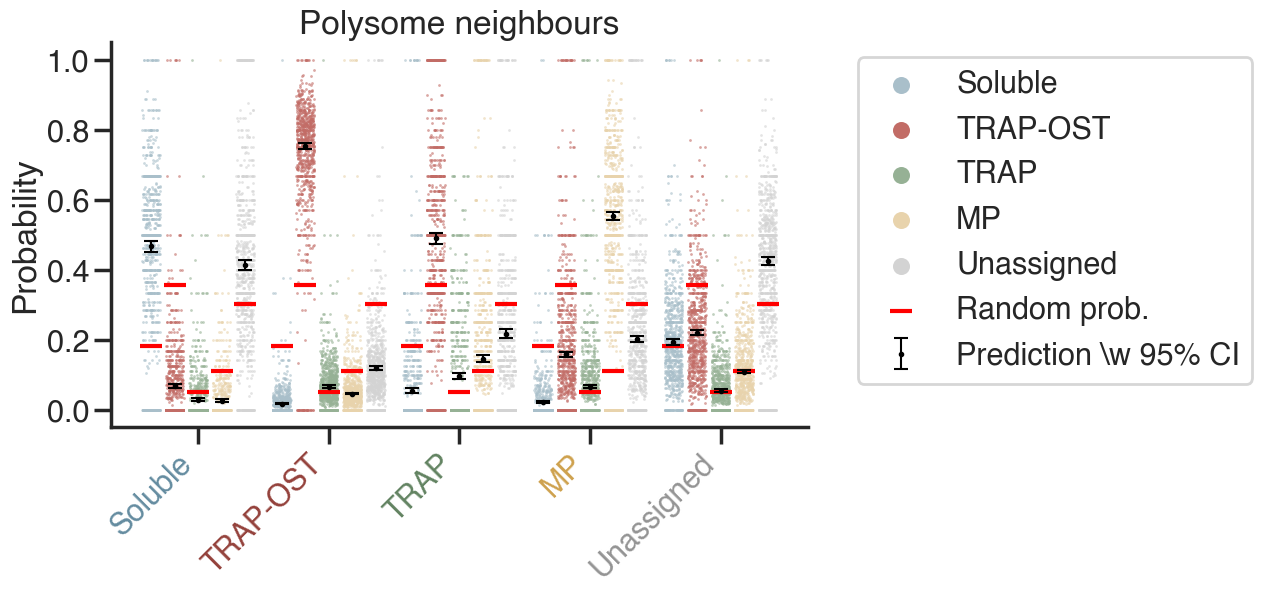

In [100]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_overall-polysome-neighbour-probability.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.18  # the width of the bars

fig, ax = plt.subplots(figsize=(9,5))

# for x, (index, name) in zip(xs, zip(order, labels)):
for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    if x == len(labels) - 1:
        ax.errorbar(xs + (x - 2) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=5, capthick=1.5, elinewidth=1.5, fmt='.', color='black', ms=6, zorder=2,
                   label='Prediction \w 95% CI')
    else:
        ax.errorbar(xs + (x - 2) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=5, capthick=1.5, elinewidth=1.5, fmt='.', color='black', ms=6, zorder=2)
#     rects = ax.bar(xs + (x - 2) * width, prediction['prob.' + index], width, label=label, linewidth=2, edgecolor='black',   
#                 yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
#                       prediction['U.prob.' + index] - prediction['prob.' + index]],
#                error_kw={'capsize': 3, 'capthick': 2, 'elinewidth': 2}, color=colors[index], alpha=0.9)
            
    for xx, (rowname, _) in zip(xs, prediction.iterrows()):
        values = polysome_dict[rowname][index]
        if xx == 0:
            sns.stripplot(x=xx + (x - 2) * width, y=values, s=2, color=colors[index], label=label,
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.7/len(labels)**2)
        else:
            sns.stripplot(x=xx + (x - 2) * width, y=values, s=2, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.7/len(labels)**2)
    
    if x == len(labels) - 1:
        ax.scatter(xs + (x - 2) * width, [null_hypothesis[index],] * len(labels), alpha=1, color='red', marker='_', 
                   s=250, label='Random prob.')
    else:
        ax.scatter(xs + (x - 2) * width, [null_hypothesis[index],] * len(labels), alpha=1, color='red', marker='_',
                   s=250)
        
ax.yaxis.grid(True)
ax.set_title('Polysome neighbours')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_ylim((-.05, 1.05))
lgnd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in range(len(labels)):
    lgnd.legendHandles[i]._sizes = [150]
    lgnd.legendHandles[i].set_alpha(1)
ax.grid(False)
sns.despine()

plt.savefig('../data/results/mblogit_translocon-overall-polysome-neighbour-probability.png', dpi=600, bbox_inches='tight')

## Leading/trailing translocon probability

In [9]:
# calculate probabilities over full dataset based purely on abundance
# our expected probably would be equal to this if our classes dont have any influence association
#  => a null hypothesis if you will
n = df_wt.shape[0]
null_hypothesis = {s: df_wt[df_wt.state == s].shape[0] / n for s in np.unique(df_wt.state)}
print(null_hypothesis)

# remove empty neighbours and pool all multipass variants into one class
raw = df_wt[df_wt.ld_state_full != 'non'].copy()
raw.ld_state_full = [s if 'NCLN' not in s else 'NCLN' for s in raw.ld_state_full]

# calculate the occurence of the neighbours in each tomogram for each state
leading_dict = {s: {s: [] for s in np.unique(raw.ld_state_full)} for s in np.unique(raw.state)}

total = 0

for i, tomo in enumerate(np.unique(raw.tomogram)):
    if i % 100 == 0: print(i)
    
    # select one tomogram
    raw_tomo = raw[raw.tomogram == tomo]
    
    for s in np.unique(raw.state):  # s is the center state
        
        raw_tomo_s = raw_tomo[raw_tomo.state == s]
        n_particles = raw_tomo_s.shape[0]  # number of particles in tomogram of class s
        
        total += n_particles
        
        for sn in np.unique(raw.ld_state_full):  # sn is the state of neighbours
            
            n_class = np.sum(raw_tomo_s.ld_state_full == sn)  # number of neighbours to s of class sn
            
            if n_particles == 0:
                leading_dict[s][sn].append(0)  # prevent division by 0
            else:
                leading_dict[s][sn].append(n_class / n_particles)
                
print(total)
            

{'NCLN': 0.10919985113509491, 'OST': 0.3555563825828061, 'Sol': 0.18293263863044287, 'TRAP': 0.05005582433941198, 'Unk': 0.30225530331224415}
0
100
200
300
400
500
600
700
800
45751


Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP


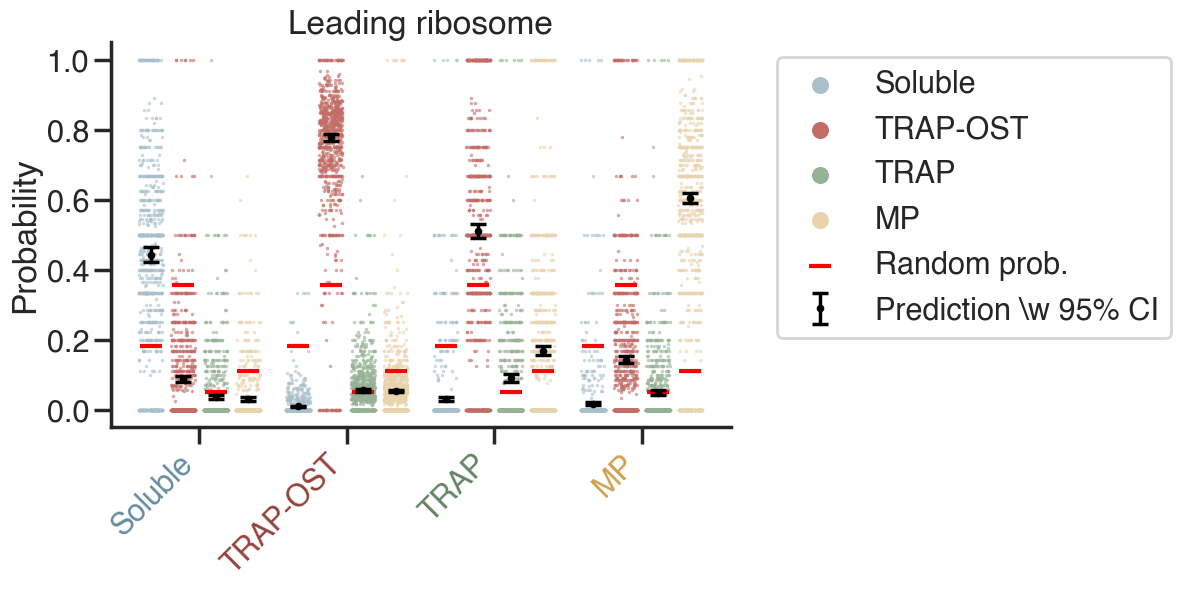

In [56]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_leading-polysome-translocon.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# DONT PLOT UNASSIGNED
order = order[:4]
labels = labels[:4]
prediction = prediction[:4]

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.22  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    if x == len(labels) - 1:
        ax.errorbar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2,
                   label='Prediction \w 95% CI')
    else:
        ax.errorbar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)
            
    for xx, (rowname, _) in zip(xs, prediction.iterrows()):
        if rowname not in order: continue
        values = leading_dict[rowname][index]
        if xx == 0:
            sns.stripplot(x=xx + (x - len(labels) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index], label=label,
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
        else:
            sns.stripplot(x=xx + (x - len(labels) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
    
    if x == len(labels) - 1:
        ax.scatter(xs + (x - len(labels) / 2 + 0.5) * width, [null_hypothesis[index],] * len(labels), 
                   alpha=1, color='red', marker='_', s=250, label='Random prob.')
    else:
        ax.scatter(xs + (x - len(labels) / 2 + 0.5) * width, [null_hypothesis[index],] * len(labels), 
                   alpha=1, color='red', marker='_', s=250)
        
ax.yaxis.grid(True)
ax.set_title('Leading ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylim((-.05, 1.05))
lgnd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in range(len(labels)):
    lgnd.legendHandles[i]._sizes = [150]
    lgnd.legendHandles[i].set_alpha(1)
ax.grid(False)
sns.despine()

plt.savefig('../data/results/mblogit_translocon-leading-polysome-neighbour-probability.png', dpi=600, bbox_inches='tight')

In [11]:
# calculate probabilities over full dataset based purely on abundance
# our expected probably would be equal to this if our classes dont have any influence association
#  => a null hypothesis if you will
n = df_wt.shape[0]
null_hypothesis = {s: df_wt[df_wt.state == s].shape[0] / n for s in np.unique(df_wt.state)}
print(null_hypothesis)

# remove empty neighbours and pool all multipass variants into one class
raw = df_wt[df_wt.tr_state_full != 'non'].copy()
raw.tr_state_full = [s if 'NCLN' not in s else 'NCLN' for s in raw.tr_state_full]

# calculate the occurence of the neighbours in each tomogram for each state
trailing_dict = {s: {s: [] for s in np.unique(raw.tr_state_full)} for s in np.unique(raw.state)}

total = 0

for i, tomo in enumerate(np.unique(raw.tomogram)):
    if i % 100 == 0: print(i)
    
    # select one tomogram
    raw_tomo = raw[raw.tomogram == tomo]
    
    for s in np.unique(raw.state):  # s is the center state
        
        raw_tomo_s = raw_tomo[raw_tomo.state == s]
        n_particles = raw_tomo_s.shape[0]  # number of particles in tomogram of class s
        
        total += n_particles
        
        for sn in np.unique(raw.tr_state_full):  # sn is the state of neighbours
            
            n_class = np.sum(raw_tomo_s.tr_state_full == sn)  # number of neighbours to s of class sn
            
            if n_particles == 0:
                trailing_dict[s][sn].append(0)  # prevent division by 0
            else:
                trailing_dict[s][sn].append(n_class / n_particles)

print(total)

{'NCLN': 0.10919985113509491, 'OST': 0.3555563825828061, 'Sol': 0.18293263863044287, 'TRAP': 0.05005582433941198, 'Unk': 0.30225530331224415}
0
100
200
300
400
500
600
700
800
45751


Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP


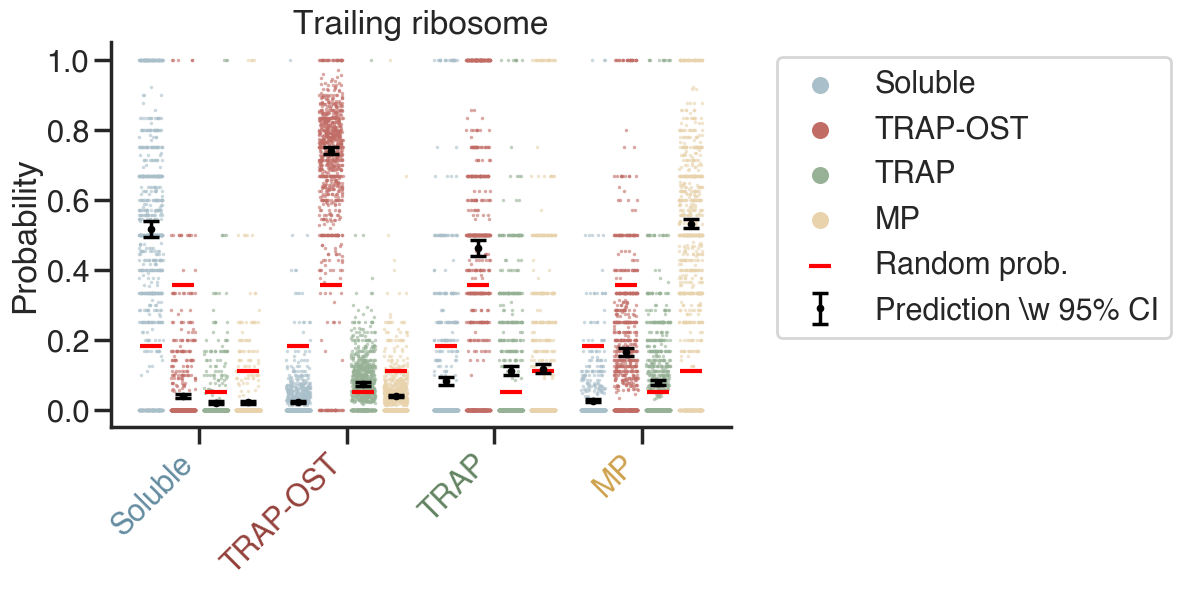

In [55]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_trailing-polysome-translocon.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# DONT PLOT UNASSIGNED
order = order[:4]
labels = labels[:4]
prediction = prediction[:4]

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.22  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    if x == len(labels) - 1:
        ax.errorbar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2,
                   label='Prediction \w 95% CI')
    else:
        ax.errorbar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)
            
    for xx, (rowname, _) in zip(xs, prediction.iterrows()):
        if rowname not in order: continue
        values = trailing_dict[rowname][index]
        if xx == 0:
            sns.stripplot(x=xx + (x - len(labels) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index], label=label,
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
        else:
            sns.stripplot(x=xx + (x - len(labels) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
    
    if x == len(labels) - 1:
        ax.scatter(xs + (x - len(labels) / 2 + 0.5) * width, [null_hypothesis[index],] * len(labels), 
                   alpha=1, color='red', marker='_', s=250, label='Random prob.')
    else:
        ax.scatter(xs + (x - len(labels) / 2 + 0.5) * width, [null_hypothesis[index],] * len(labels), 
                   alpha=1, color='red', marker='_', s=250)
        
ax.yaxis.grid(True)
ax.set_title('Trailing ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylim((-.05, 1.05))
lgnd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for i in range(len(labels)):
    lgnd.legendHandles[i]._sizes = [150]
    lgnd.legendHandles[i].set_alpha(1)
ax.grid(False)
sns.despine()

plt.savefig('../data/results/mblogit_translocon-trailing-polysome-neighbour-probability.png', dpi=600, bbox_inches='tight')

## Leading/trailing translocon probability extended

In [67]:
# calculate probabilities over full dataset based purely on abundance
# our expected probably would be equal to this if our classes dont have any influence association
#  => a null hypothesis if you will
raw = df_wt.copy()
ncln_dict = {'NCLN': 'NCLN', 'NCLNCCDC47': 'NCLN', 'NCLNTRAP': 'NCLNTRAP', 'NCLNTRAPCCDC47': 'NCLNTRAP'}
raw.state_full = [ncln_dict[s] if 'NCLN' in s else s for s in raw.state_full]
raw.ld_state_full = [ncln_dict[s] if 'NCLN' in s else s for s in raw.ld_state_full]
n = raw.shape[0]
null_hypothesis = {s: raw[raw.state_full == s].shape[0] / n for s in np.unique(raw.state_full)}
print(null_hypothesis)

{'NCLN': 0.06311127651656122, 'NCLNTRAP': 0.04608857461853368, 'OST': 0.3555563825828061, 'Sol': 0.18293263863044287, 'TRAP': 0.05005582433941198, 'Unk': 0.30225530331224415}


In [62]:
# calculate the occurence of the neighbours in each tomogram for each state
leading_dict_ext = {s: {s: [] for s in np.unique(raw.ld_state_full)} for s in np.unique(raw.state_full)}
for i, tomo in enumerate(np.unique(raw.tomogram)):
    if i % 100 == 0: print(i)
    
    # select one tomogram
    raw_tomo = raw[raw.tomogram == tomo]
    
    for s in np.unique(raw.state_full):  # s is the center state
        
        raw_tomo_s = raw_tomo[raw_tomo.state_full == s]
        n_particles = raw_tomo_s.shape[0]  # number of particles in tomogram of class s
        
        for sn in np.unique(raw.ld_state_full):  # sn is the state of neighbours
            
            n_class = np.sum(raw_tomo_s.ld_state_full == sn)  # number of neighbours to s of class sn
            
            if n_particles == 0:
                leading_dict_ext[s][sn].append(0)  # prevent division by 0
            else:
                leading_dict_ext[s][sn].append(n_class / n_particles)
            

{'NCLN': 0.06311127651656122, 'NCLNTRAP': 0.04608857461853368, 'OST': 0.3555563825828061, 'Sol': 0.18293263863044287, 'TRAP': 0.05005582433941198, 'Unk': 0.30225530331224415}
0
100
200
300
400
500
600
700
800


In [85]:
rarr

array([[0.01321648, 0.00965166, 0.07445904, 0.03830894, 0.01048247,
        0.06329696],
       [0.02487929, 0.01816872, 0.14016497, 0.07211443, 0.01973266,
        0.11915298],
       [0.02745933, 0.02005286, 0.15470041, 0.07959288, 0.02177898,
        0.13150944],
       [0.02522422, 0.01842061, 0.14210822, 0.07311423, 0.02000623,
        0.12080492],
       [0.01964232, 0.01434429, 0.11066092, 0.05693469, 0.01557903,
        0.09407186],
       [0.01626927, 0.01188104, 0.09165785, 0.04715768, 0.01290375,
        0.07791752]])

In [84]:
prediction

,prob.NCLN,prob.NCLNTRAP,prob.non,prob.OST,prob.Sol,prob.TRAP,prob.Unk,L.prob.NCLN,L.prob.NCLNTRAP,L.prob.non,...,L.prob.Sol,L.prob.TRAP,L.prob.Unk,U.prob.NCLN,U.prob.NCLNTRAP,U.prob.non,U.prob.OST,U.prob.Sol,U.prob.TRAP,U.prob.Unk
Sol,0.003660,0.002515,0.790584,0.018172,0.092106,0.007471,0.085492,0.002971,0.001960,0.782728,...,0.086059,0.006414,0.081086,0.004509,0.003226,0.798230,0.020109,0.098532,0.008701,0.090114
OST,0.010571,0.010659,0.605787,0.304766,0.003679,0.021912,0.042626,0.009658,0.009563,0.594989,...,0.003143,0.020229,0.040332,0.011569,0.011878,0.616482,0.315784,0.004307,0.023733,0.045044
TRAP,0.045106,0.029115,0.564906,0.219610,0.013225,0.039841,0.088197,0.040290,0.025079,0.550539,...,0.010716,0.035226,0.081135,0.050466,0.033779,0.579165,0.232525,0.016311,0.045032,0.095809
NCLN,0.193379,0.065723,0.600322,0.042987,0.005784,0.018564,0.073241,0.184976,0.059404,0.588792,...,0.004390,0.015835,0.067442,0.202070,0.072661,0.611741,0.047830,0.007619,0.021754,0.079496
NCLNTRAP,0.124685,0.048033,0.688767,0.057598,0.006240,0.015624,0.059053,0.116590,0.042521,0.676257,...,0.004584,0.012806,0.053197,0.133257,0.054220,0.701007,0.064148,0.008487,0.019051,0.065508
Unk,0.020782,0.009556,0.742213,0.060473,0.043998,0.012757,0.110222,0.019423,0.008498,0.735238,...,0.040885,0.011537,0.105637,0.022234,0.010744,0.749066,0.064093,0.047335,0.014104,0.114980


Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP
NCLNTRAP TRAP-MP
Unk Unassigned


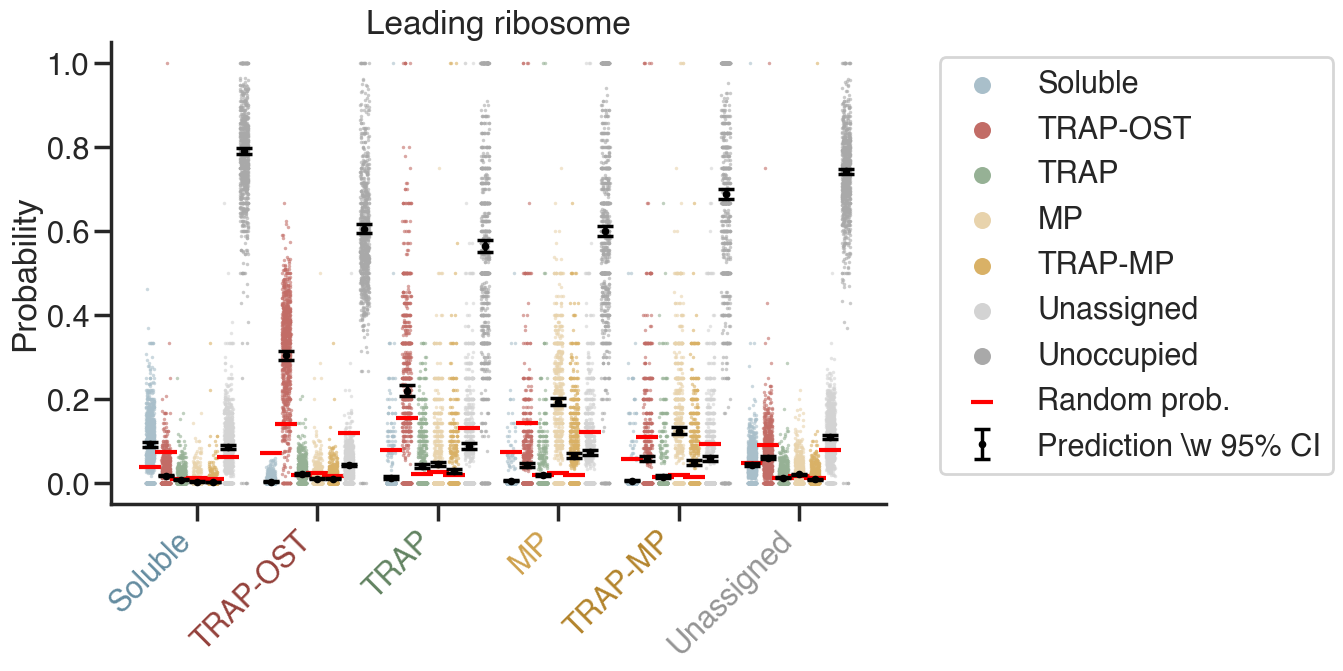

In [97]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'NCLNTRAP', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'TRAP-MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_leading-polysome-translocon_extended.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# adjust expectation value based on number of unnocupied ribosomes
null_arr = [null_hypothesis[o] for o in order]
rarr = np.zeros((len(prediction['prob.non']), ) * 2)
for i, pnon in enumerate(prediction['prob.non']):
    rarr[i, :] = np.array(null_arr) * (1 - pnon)

# DONT PLOT UNASSIGNED

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    if x == len(labels) - 1:
        ax.errorbar(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2,
                   label='Prediction \w 95% CI')
    else:
        ax.errorbar(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)
            
    for xx, (rowname, _) in zip(xs, prediction.iterrows()):
        if rowname not in order: continue
        values = leading_dict_ext[rowname][index]
        if xx == 0:
            sns.stripplot(x=xx + (x - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2, label=label)
        else:
            sns.stripplot(x=xx + (x - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
    
    # get right expectation value for each central ribo state
    if x == len(labels) - 1:
        ax.scatter(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, rarr[:, x], 
                   alpha=1, color='red', marker='_', s=250, label='Random prob.')
    else:
        ax.scatter(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, rarr[:, x], 
                   alpha=1, color='red', marker='_', s=250)
        
# plot prediction of unoccupied
ax.errorbar(xs + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + 'non'], 
                    yerr=[prediction['prob.' + 'non'] - prediction['L.prob.' + 'non'], 
                          prediction['U.prob.' + 'non'] - prediction['prob.' + 'non']], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)

# and the stripplot for unoccupied
for xx, (rowname, _) in zip(xs, prediction.iterrows()):
    values = leading_dict_ext[rowname]['non']
    if xx == 0:
        sns.stripplot(x=xx + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color='darkgray',
                      zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2,
                      label='Unoccupied')
    else:
        sns.stripplot(x=xx + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color='darkgray',
                      zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
        
ax.yaxis.grid(True)
ax.set_title('Leading ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylim((-.05, 1.05))

#get handles and labels
handles, lbls = plt.gca().get_legend_handles_labels()

#specify order of items in legend
legend_order = [0, 1, 2, 3, 4, 5, 7, 6, 8]

#add legend to plot
lgnd = ax.legend([handles[idx] for idx in legend_order],[lbls[idx] for idx in legend_order],
                 bbox_to_anchor=(1.05, 1), loc='upper left')

for i in range(len(labels) + 1):
    lgnd.legendHandles[i]._sizes = [150]
    lgnd.legendHandles[i].set_alpha(1)

# remove grid and remove top and right spines    
ax.grid(False)
sns.despine()

plt.savefig('../data/results/mblogit_translocon-leading-polysome-neighbour-probability_extended.png', 
            dpi=600, bbox_inches='tight')

Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP
NCLNTRAP TRAP-MP
Unk Unassigned


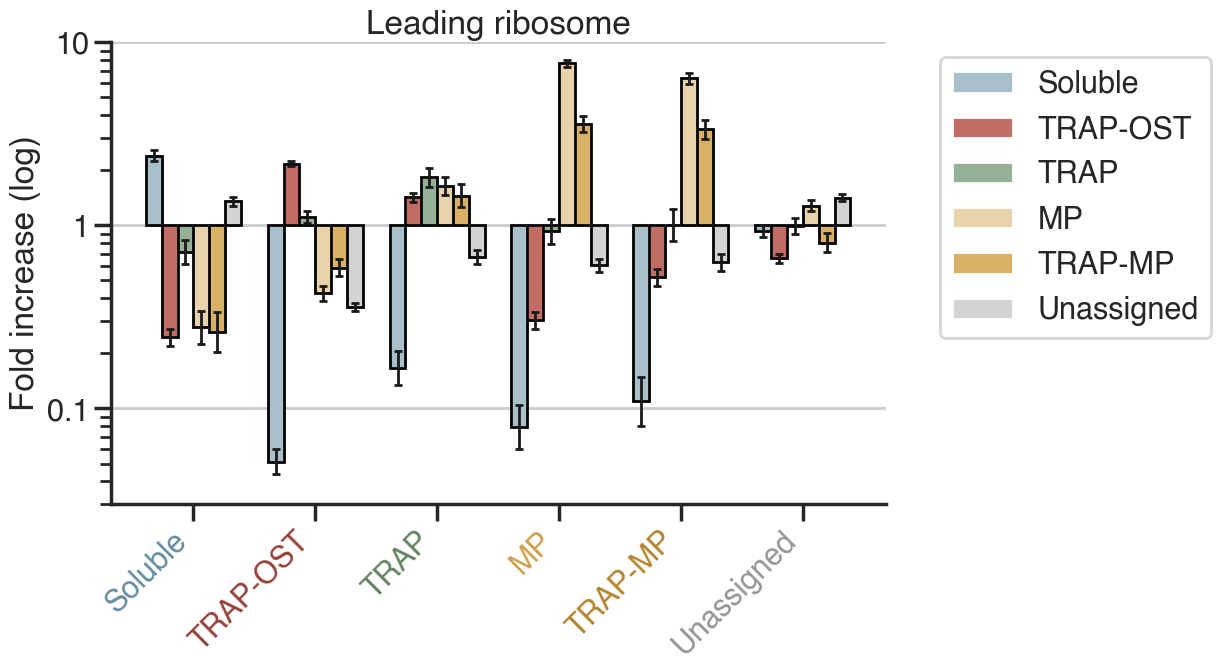

In [120]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'NCLNTRAP', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'TRAP-MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_leading-polysome-translocon_extended.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# adjust expectation value based on number of unnocupied ribosomes
null_arr = [null_hypothesis[o] for o in order]
rarr = np.zeros((len(prediction['prob.non']), ) * 2)
for i, pnon in enumerate(prediction['prob.non']):
    rarr[i, :] = np.array(null_arr) * (1 - pnon)

# DONT PLOT UNASSIGNED

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    rects = ax.bar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index] / rarr[:, x] - 1,
                   width, label=label, linewidth=2, bottom=[1, ] * len(labels), color=colors[label])
            
    rects = ax.bar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index] / rarr[:, x] - 1, 
                   width, linewidth=2, edgecolor='black', fill=False,
                   yerr=[prediction['prob.' + index] / rarr[:, x] - prediction['L.prob.' + index] / rarr[:, x], 
                         prediction['U.prob.' + index] / rarr[:, x] - prediction['prob.' + index] / rarr[:, x]],
                   error_kw={'capsize': 3, 'capthick': 2, 'elinewidth': 2},
                   bottom=[1, ] * len(labels))
    
        
ax.yaxis.grid(True)
ax.set_title('Leading ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]

ax.set_ylabel('Fold increase (log)')
ax.set_yscale('log')
ax.yaxis.grid(True)
ax.set_ylim(0.03, 10)

ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels(labels=[], minor=True)
ax.set_yticklabels(labels=['0.1', '1', '10'])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# remove grid and remove top and right spines    
sns.despine()

plt.savefig('../data/results/mblogit_translocon-leading-polysome-neighbour-probability_extended_fold.png', 
            dpi=600, bbox_inches='tight')

In [7]:
# calculate probabilities over full dataset based purely on abundance
# our expected probably would be equal to this if our classes dont have any influence association
#  => a null hypothesis if you will
raw = df_wt.copy()
ncln_dict = {'NCLN': 'NCLN', 'NCLNCCDC47': 'NCLN', 'NCLNTRAP': 'NCLNTRAP', 'NCLNTRAPCCDC47': 'NCLNTRAP'}
raw.state_full = [ncln_dict[s] if 'NCLN' in s else s for s in raw.state_full]
raw.tr_state_full = [ncln_dict[s] if 'NCLN' in s else s for s in raw.tr_state_full]
n = raw.shape[0]
null_hypothesis = {s: raw[raw.state_full == s].shape[0] / n for s in np.unique(raw.state_full)}
print(null_hypothesis)

# calculate the occurence of the neighbours in each tomogram for each state
trailing_dict_ext = {s: {s: [] for s in np.unique(raw.tr_state_full)} for s in np.unique(raw.state_full)}
for i, tomo in enumerate(np.unique(raw.tomogram)):
    if i % 100 == 0: print(i)
    
    # select one tomogram
    raw_tomo = raw[raw.tomogram == tomo]
    
    for s in np.unique(raw.state_full):  # s is the center state
        
        raw_tomo_s = raw_tomo[raw_tomo.state_full == s]
        n_particles = raw_tomo_s.shape[0]  # number of particles in tomogram of class s
        
        for sn in np.unique(raw.tr_state_full):  # sn is the state of neighbours
            
            n_class = np.sum(raw_tomo_s.tr_state_full == sn)  # number of neighbours to s of class sn
            
            if n_particles == 0:
                trailing_dict_ext[s][sn].append(0)  # prevent division by 0
            else:
                trailing_dict_ext[s][sn].append(n_class / n_particles)
            

{'NCLN': 0.06311127651656122, 'NCLNTRAP': 0.04608857461853368, 'OST': 0.3555563825828061, 'Sol': 0.18293263863044287, 'TRAP': 0.05005582433941198, 'Unk': 0.30225530331224415}
0
100
200
300
400
500
600
700
800


Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP
NCLNTRAP TRAP-MP
Unk Unassigned


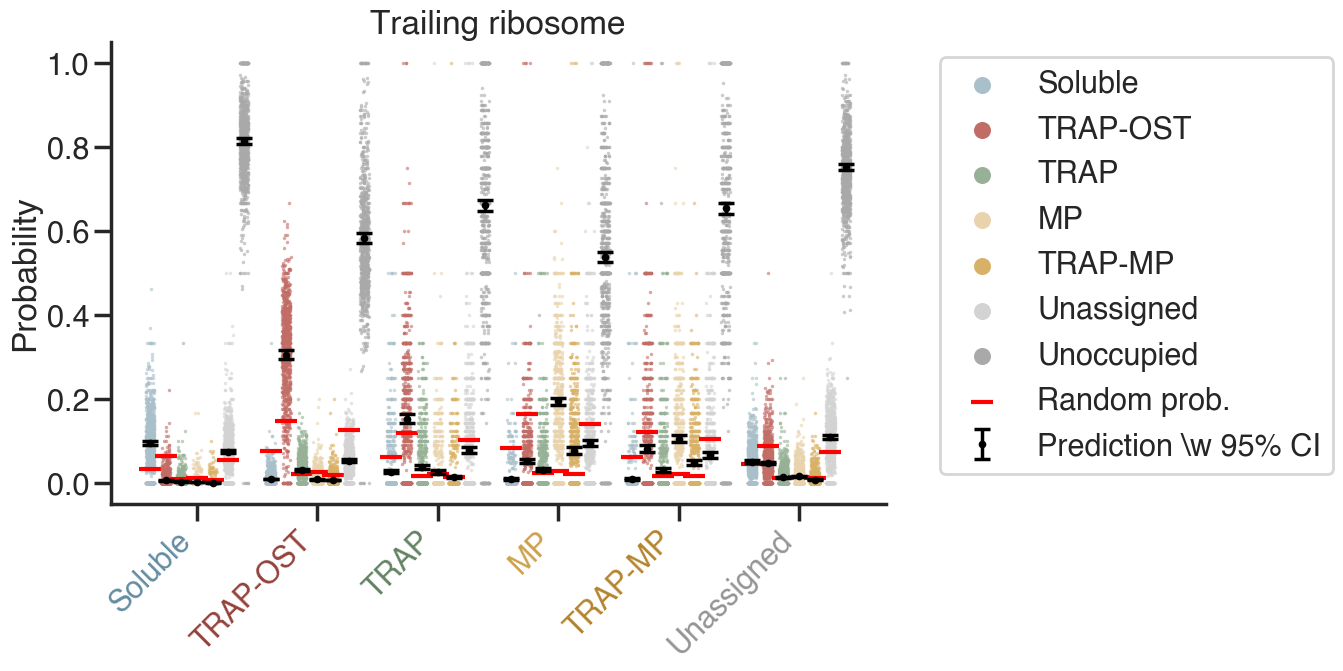

In [8]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'NCLNTRAP', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'TRAP-MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_trailing-polysome-translocon_extended.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# adjust expectation value based on number of unnocupied ribosomes
null_arr = [null_hypothesis[o] for o in order]
rarr = np.zeros((len(prediction['prob.non']), ) * 2)
for i, pnon in enumerate(prediction['prob.non']):
    rarr[i, :] = np.array(null_arr) * (1 - pnon)

# DONT PLOT UNASSIGNED

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    if x == len(labels) - 1:
        ax.errorbar(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2,
                   label='Prediction \w 95% CI')
    else:
        ax.errorbar(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + index], 
                    yerr=[prediction['prob.' + index] - prediction['L.prob.' + index], 
                          prediction['U.prob.' + index] - prediction['prob.' + index]], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)
            
    for xx, (rowname, _) in zip(xs, prediction.iterrows()):
        if rowname not in order: continue
        values = trailing_dict_ext[rowname][index]
        if xx == 0:
            sns.stripplot(x=xx + (x - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2, label=label)
        else:
            sns.stripplot(x=xx + (x - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color=colors[index],
                          zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
    
    # get right expectation value for each central ribo state
    if x == len(labels) - 1:
        ax.scatter(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, rarr[:, x], 
                   alpha=1, color='red', marker='_', s=250, label='Random prob.')
    else:
        ax.scatter(xs + (x - (len(labels) + 1) / 2 + 0.5) * width, rarr[:, x], 
                   alpha=1, color='red', marker='_', s=250)
        
# plot prediction of unoccupied
ax.errorbar(xs + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, prediction['prob.' + 'non'], 
                    yerr=[prediction['prob.' + 'non'] - prediction['L.prob.' + 'non'], 
                          prediction['U.prob.' + 'non'] - prediction['prob.' + 'non']], 
                capsize=6, capthick=2.5, elinewidth=2.5, fmt='.', color='black', ms=9, zorder=2)

# and the stripplot for unoccupied
for xx, (rowname, _) in zip(xs, prediction.iterrows()):
    values = trailing_dict_ext[rowname]['non']
    if xx == 0:
        sns.stripplot(x=xx + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color='darkgray',
                      zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2,
                      label='Unoccupied')
    else:
        sns.stripplot(x=xx + ((x + 1) - (len(labels) + 1) / 2 + 0.5) * width, y=values, s=2.5, color='darkgray',
                      zorder=1, ax=ax, alpha=0.6, native_scale=True, jitter=1.3/len(labels)**2)
        
ax.yaxis.grid(True)
ax.set_title('Trailing ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]
ax.set_ylabel('Probability')
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_ylim((-.05, 1.05))

#get handles and labels
handles, lbls = plt.gca().get_legend_handles_labels()

#specify order of items in legend
legend_order = [0, 1, 2, 3, 4, 5, 7, 6, 8]

#add legend to plot
lgnd = ax.legend([handles[idx] for idx in legend_order],[lbls[idx] for idx in legend_order],
                 bbox_to_anchor=(1.05, 1), loc='upper left')

for i in range(len(labels) + 1):
    lgnd.legendHandles[i]._sizes = [150]
    lgnd.legendHandles[i].set_alpha(1)

# remove grid and remove top and right spines    
ax.grid(False)
sns.despine()

plt.savefig('../data/results/mblogit_translocon-trailing-polysome-neighbour-probability_extended.png', 
            dpi=600, bbox_inches='tight')

Sol Soluble
OST TRAP-OST
TRAP TRAP
NCLN MP
NCLNTRAP TRAP-MP
Unk Unassigned


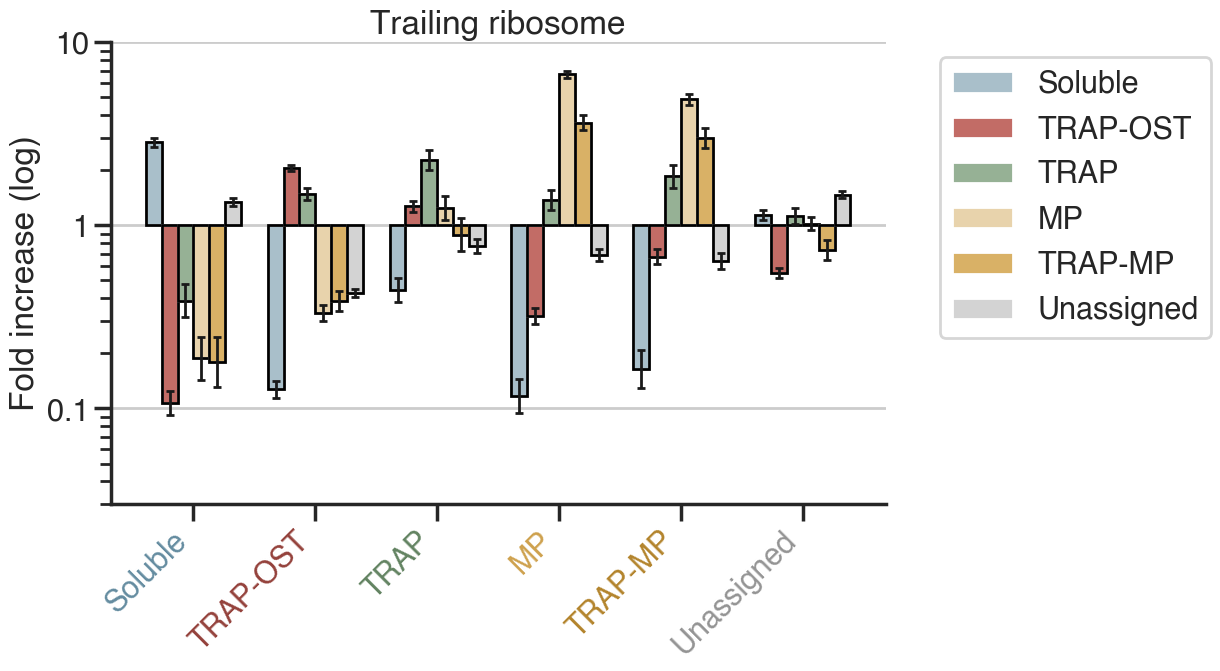

In [123]:
order = ['Sol', 'OST', 'TRAP', 'NCLN', 'NCLNTRAP', 'Unk']
labels = ['Soluble', 'TRAP-OST', 'TRAP', 'MP', 'TRAP-MP', 'Unassigned']

prediction = pd.read_csv("../data/results/mblogit_trailing-polysome-translocon_extended.csv", 
                           delimiter=',', index_col=0)
prediction = prediction.loc[order, :]

# adjust expectation value based on number of unnocupied ribosomes
null_arr = [null_hypothesis[o] for o in order]
rarr = np.zeros((len(prediction['prob.non']), ) * 2)
for i, pnon in enumerate(prediction['prob.non']):
    rarr[i, :] = np.array(null_arr) * (1 - pnon)

# DONT PLOT UNASSIGNED

colors = {'NCLN': '#e8d3ac', 'NCLNTRAP': '#d9b166', 'TRAP-MP': '#d9b166' ,'TRAP': '#96b195', 'OST': '#c26c66', 
          'TRAP-OST': '#c26c66', 'Unk': 'lightgray', 'non': 'white', 'Sol': '#a9bfca', 'MP': '#e8d3ac',
          'Unassigned': 'lightgray', 'Unoccupied': 'white', 'Soluble': '#a9bfca'}

xs = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))

for x, (index, label) in enumerate(zip(order, labels)):
    print(index, label)
    rects = ax.bar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index] / rarr[:, x] - 1,
                   width, label=label, linewidth=2, bottom=[1, ] * len(labels), color=colors[label])
            
    rects = ax.bar(xs + (x - len(labels) / 2 + 0.5) * width, prediction['prob.' + index] / rarr[:, x] - 1, 
                   width, linewidth=2, edgecolor='black', fill=False,
                   yerr=[prediction['prob.' + index] / rarr[:, x] - prediction['L.prob.' + index] / rarr[:, x], 
                         prediction['U.prob.' + index] / rarr[:, x] - prediction['prob.' + index] / rarr[:, x]],
                   error_kw={'capsize': 3, 'capthick': 2, 'elinewidth': 2},
                   bottom=[1, ] * len(labels))
    
        
ax.yaxis.grid(True)
ax.set_title('Trailing ribosome')
ax.set_xticks(xs)
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
[t.set_color(adjust_lightness(colors[t.get_text()], 0.7)) for t in ax.xaxis.get_ticklabels()]

ax.set_ylabel('Fold increase (log)')
ax.set_yscale('log')
ax.yaxis.grid(True)
ax.set_ylim(0.03, 10)

ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels(labels=[], minor=True)
ax.set_yticklabels(labels=['0.1', '1', '10'])

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# remove grid and remove top and right spines    
sns.despine()

plt.savefig('../data/results/mblogit_translocon-trailing-polysome-neighbour-probability_extended_fold.png', 
            dpi=600, bbox_inches='tight')